In [1]:
from datetime import date, timedelta
from constants import *
from bars import plot_bars as plot_areas, unique_people_tested, daily_vaccinations, population_vaccinated
from phe import *
from phe import map_data as phe_map_data, latest_changes
from zoe import latest_map_data as zoe_map_data
from plotting import *
from vaccination import vaccination_dashboard, vaccination_changes
for_date = '*'

In [2]:
latest_changes(s.new_cases_sum, s.new_admissions_sum, s.new_deaths_sum)

Latest for England:
1,806 cases (7 day average) as of Thu 20 May, +37.9 since Wed 19 May
85 hospitalised (7 day average) as of Sun 23 May, +8.6 since Wed 19 May
4 died (7 day average) as of Thu 20 May, +0.0 since Wed 19 May


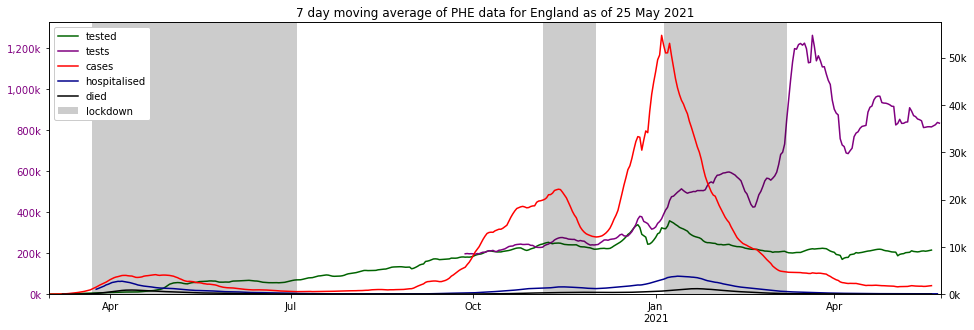

In [3]:
plot_summary(left_series=(s.unique_people_tested_sum, s.new_virus_tests_sum),
             right_series=(s.new_cases_sum, s.new_admissions_sum, s.new_deaths_sum))

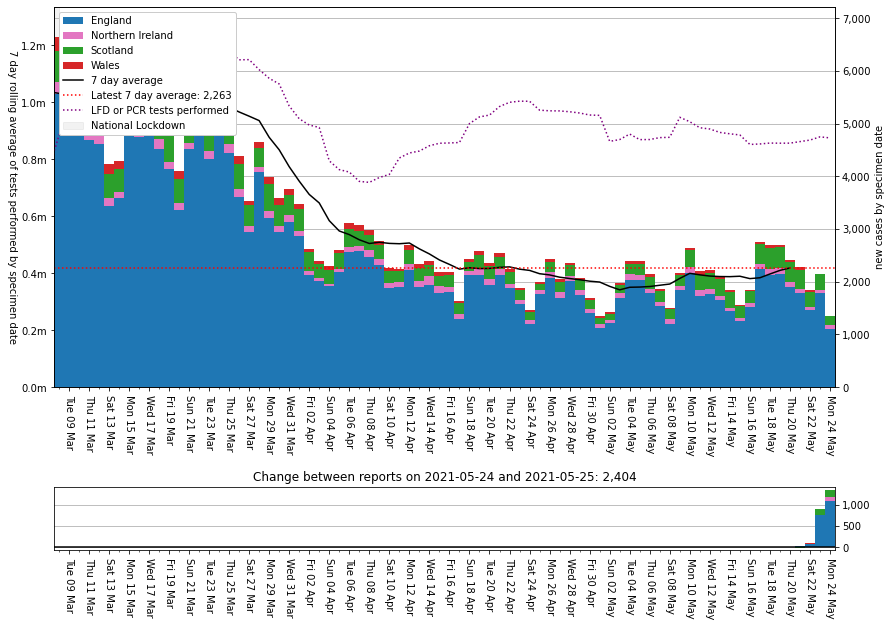

In [4]:
plot_areas(for_date, 'cases_nations', earliest=lockdown3[1], date_format='%a %d %b')

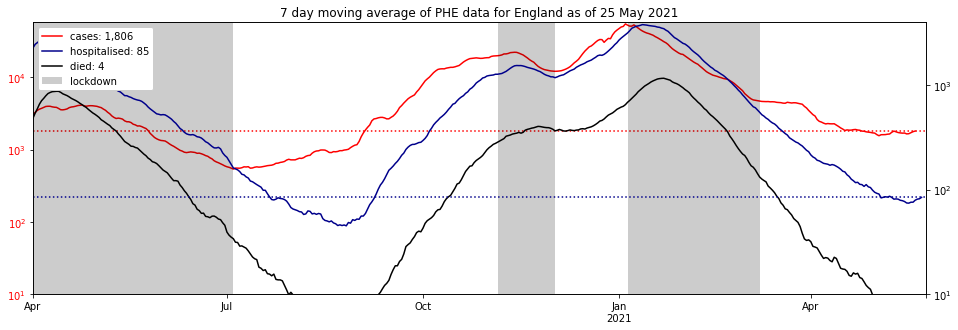

In [5]:
plot_summary(earliest_date='2020-04-01', show_latest='lines', log=True,
             left_series=(s.new_cases_sum,), left_formatter=per1k_formatter,
             right_series=(s.new_admissions_sum, s.new_deaths_sum), right_formatter=per0k_formatter)

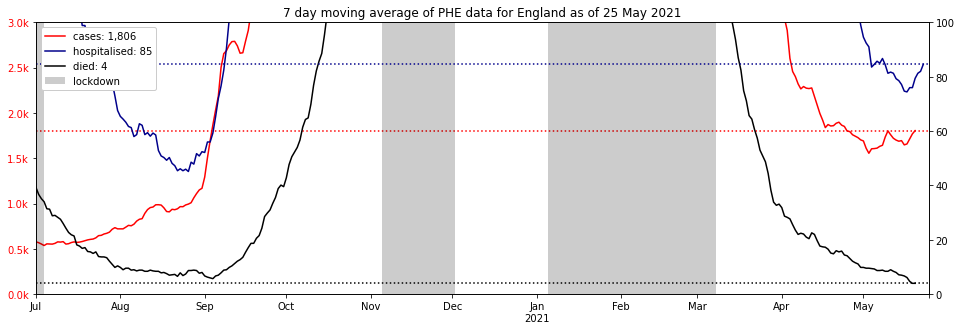

In [6]:
plot_summary(earliest_date='2020-07-01', show_latest='lines',
             left_series=(s.new_cases_sum,), left_formatter=per0k_formatter, left_ymax=3_000,
             right_series=(s.new_admissions_sum, s.new_deaths_sum), right_formatter=per0_formatter, right_ymax=100)

In [7]:
vaccination_changes()

,,Complete (Total),First Dose (Total),Second Dose (Total),Complete (New),First Dose (New),Second Dose (New)
,,,,,,,
England,24 May 21,"+19,707,303","+31,922,289","+19,707,303","+279,672","+95,484","+279,672"
Northern Ireland,24 May 21,"+620,764","+1,026,443","+620,764","+8,700","+4,418","+8,700"
Scotland,24 May 21,"+1,881,214","+3,138,366","+1,881,214","+29,035","+16,421","+29,035"
Wales,24 May 21,"+1,019,230","+2,105,319","+1,019,230","+15,548","+6,056","+15,548"


,areaName,areaCode,full,any,partial,population,full_pct,partial_pct,none_pct
0,England,E92000001,19707303.0,31922289.0,12214986.0,56286961,35.012199,21.701271,43.286530
1,Northern Ireland,N92000002,620764.0,1026443.0,405679.0,1893667,32.781054,21.422932,45.796014
2,Scotland,S92000003,1881214.0,3138366.0,1257152.0,5463300,34.433657,23.010854,42.555488
3,Wales,W92000004,1019230.0,2105319.0,1086089.0,3152879,32.326962,34.447532,33.225506


'partial: 38,192,417 (57.2%), full: 23,228,511'

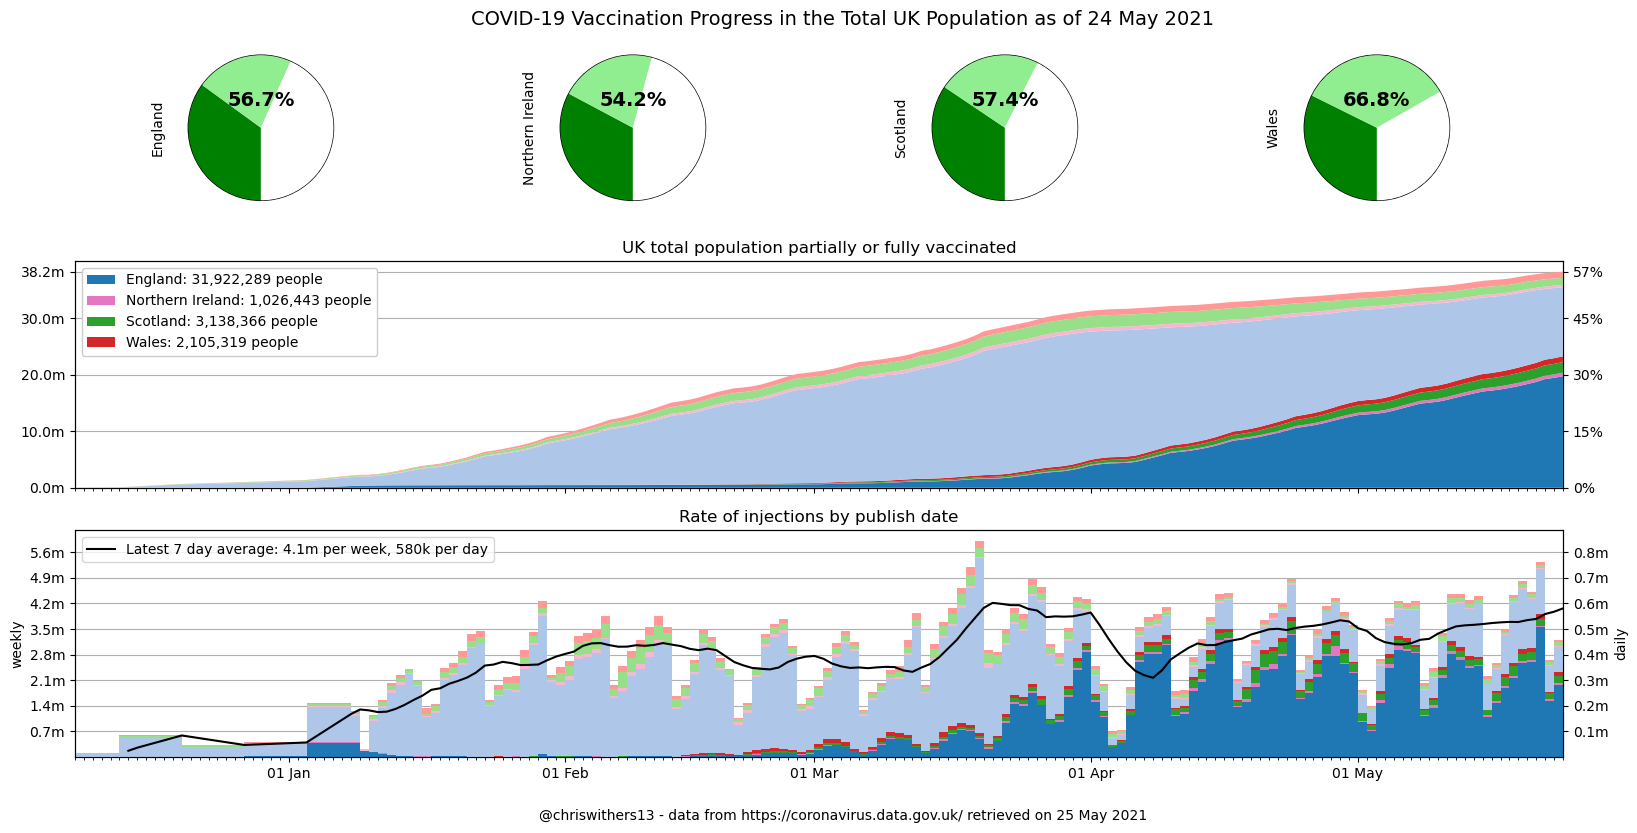

In [8]:
results = vaccination_dashboard()
partial = results['any'].sum()
population = results['population'].sum()
display(results, f"partial: {partial:,.0f} ({partial/population:.1%}), full: {results['full'].sum():,.0f}")

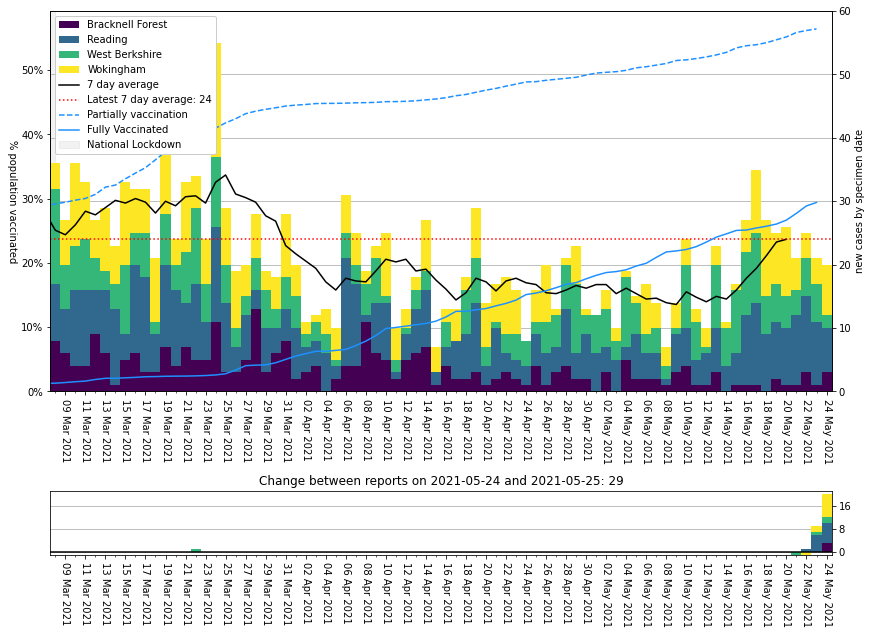

In [9]:
plot_areas(for_date, areas=my_areas, earliest=lockdown3[1], ylim=60,  lines=population_vaccinated)

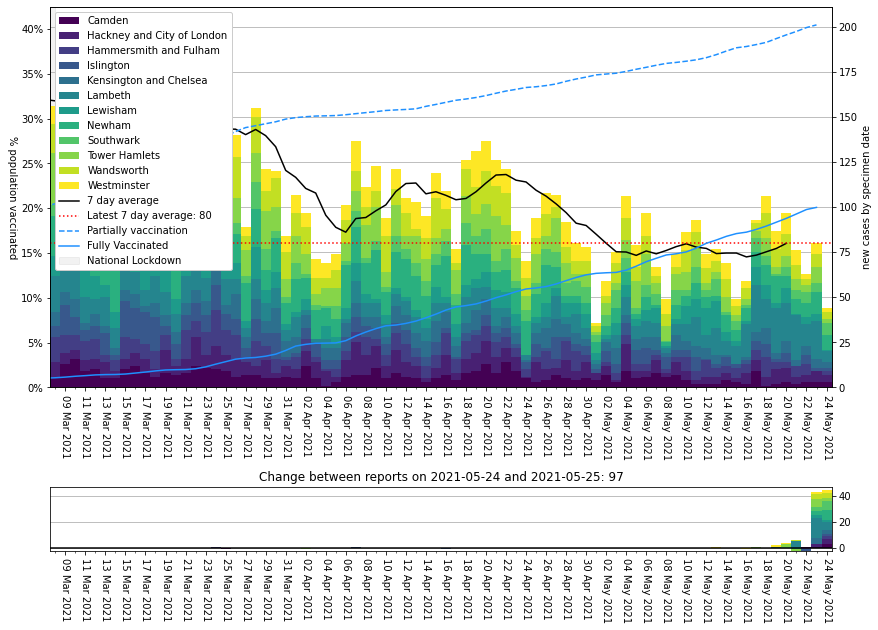

In [10]:
plot_areas(for_date, areas=london_areas, earliest=lockdown3[1], lines=population_vaccinated)

In [11]:
data = recent_phe_data_summed(for_date)
top_10_cols = [area_name,per100k,new_cases_by_specimen_date, specimen_date]

In [12]:
top_10 = data.sort_values(per100k, ascending=False)[:10][top_10_cols]
top_10

,areaName,"per 100,000 people",newCasesBySpecimenDate,Specimen date
areaCode,,,,
E08000001,Bolton,345.679012,994.0,2021-05-24
E06000008,Blackburn with Darwen,300.609235,450.0,2021-05-24
E07000125,Rossendale,184.661873,132.0,2021-05-24
E06000055,Bedford,174.849387,303.0,2021-05-24
S12000005,Clackmannanshire,141.637563,73.0,2021-05-24
S12000049,Glasgow City,126.042456,798.0,2021-05-24
E08000034,Kirklees,97.774605,430.0,2021-05-24
S12000038,Renfrewshire,91.010609,163.0,2021-05-24
S12000011,East Renfrewshire,90.024076,86.0,2021-05-24


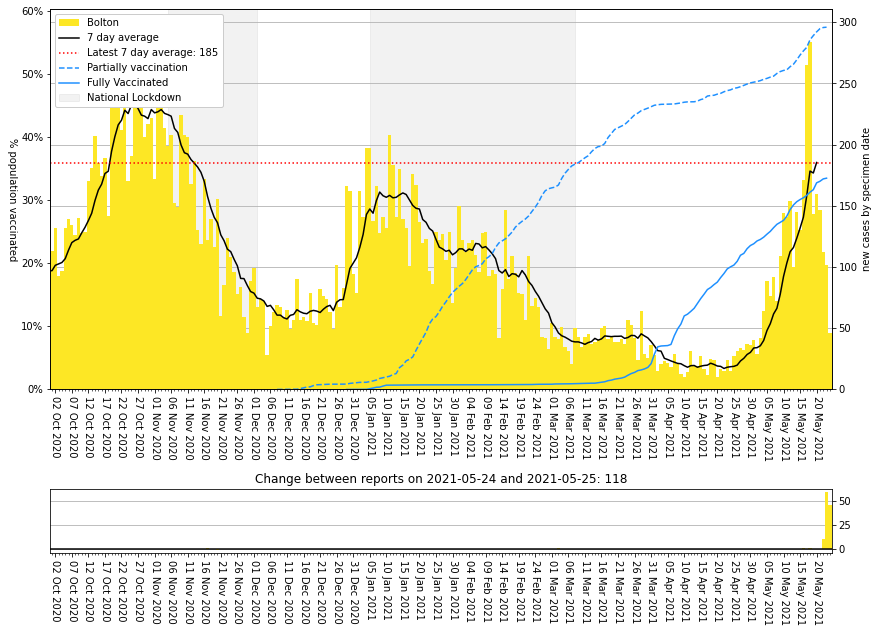

In [13]:
plot_areas(for_date, areas=[top_10.iloc[0].name], colormap='viridis_r', lines=population_vaccinated)

In [14]:
top_10 = data.sort_values(new_cases_by_specimen_date, ascending=False)[:10][top_10_cols]
top_10

,areaName,"per 100,000 people",newCasesBySpecimenDate,Specimen date
areaCode,,,,
E08000001,Bolton,345.679012,994.0,2021-05-24
S12000049,Glasgow City,126.042456,798.0,2021-05-24
E06000008,Blackburn with Darwen,300.609235,450.0,2021-05-24
E08000034,Kirklees,97.774605,430.0,2021-05-24
E08000003,Manchester,65.116178,360.0,2021-05-24
E06000055,Bedford,174.849387,303.0,2021-05-24
E08000032,Bradford,51.502846,278.0,2021-05-24
E08000035,Leeds,33.789790,268.0,2021-05-24
E08000025,Birmingham,23.033484,263.0,2021-05-24


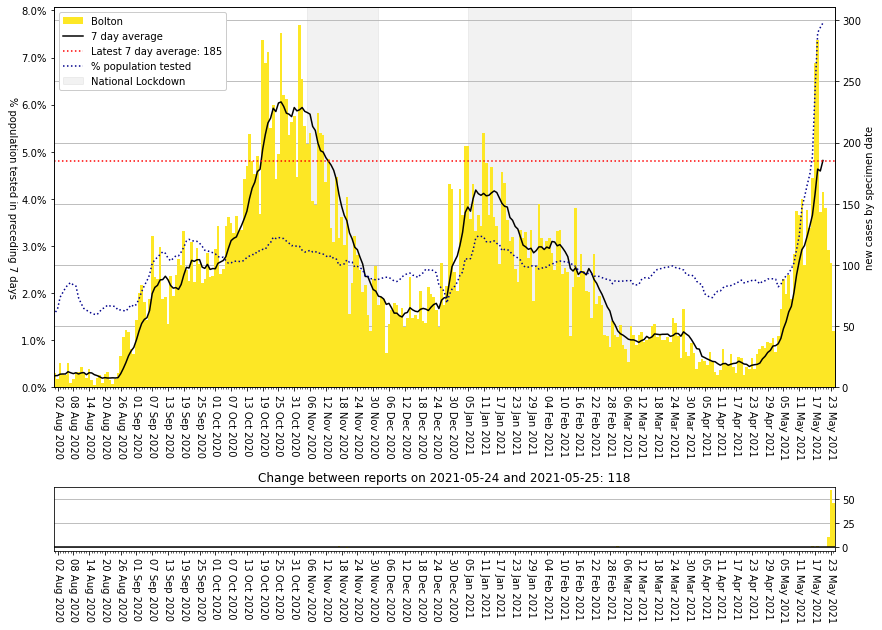

In [15]:
plot_areas(for_date, areas=[top_10.iloc[0].name], colormap='viridis_r', lines=unique_people_tested, earliest='2020-08')

In [16]:
zoe_date, zoe_df = zoe_map_data()
phe_recent_date, phe_recent_geo, phe_recent_title = phe_map_data(for_date)
zoe_max = 0.6
phe_max = 0.25

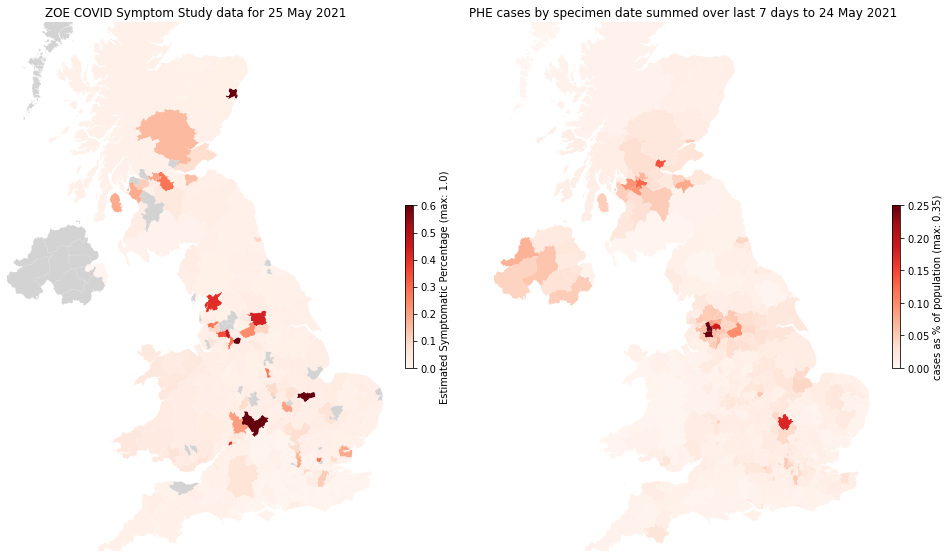

In [17]:
matplotlib_zoe_vs_phe_map(zoe_df, zoe_date, zoe_max, phe_recent_geo, phe_recent_title, phe_max)

In [18]:
bokeh_zoe_vs_phe_map(zoe_df, zoe_date, zoe_max, phe_recent_geo, phe_recent_title, phe_max)

Loading BokehJS ...